<a href="https://colab.research.google.com/github/mdirshe/Abdul/blob/main/MDIRRSE_25133057.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[1] DATASET DESCRIPTION & EXPLORATORY ANALYSIS
------------------------------------------------------------
CSV: Cybersecurity Intrusion Detection.csv
Shape: 9537 rows × 11 columns

Dtypes:
 session_id              object
network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object

Missing values per column:
 session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64

Head(5):
   session_id  network_packet_size protocol_type  login_attempts  \
0  SID_00001             

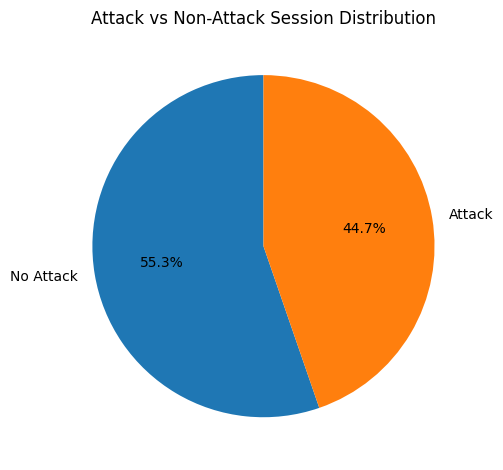

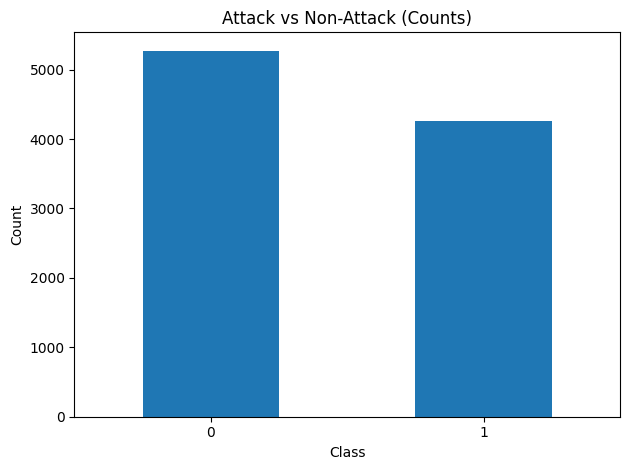

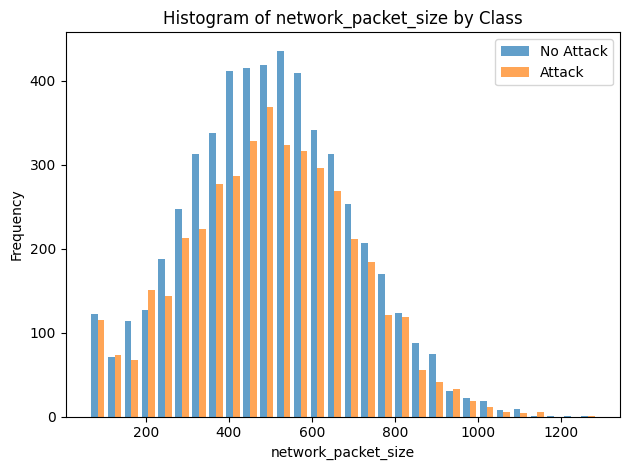

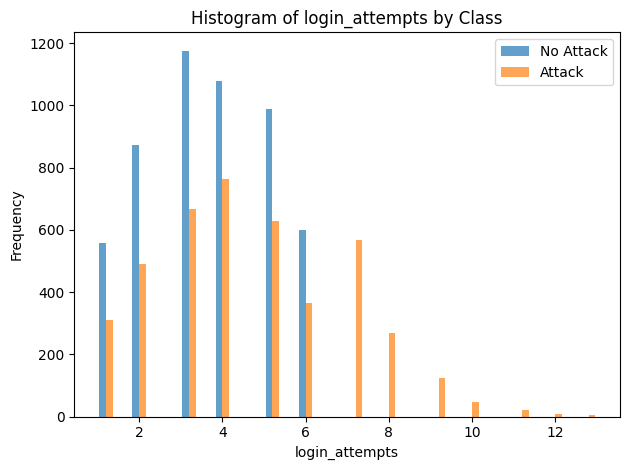

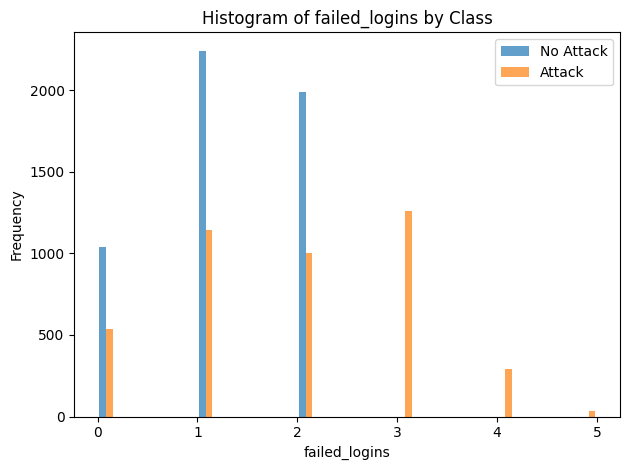

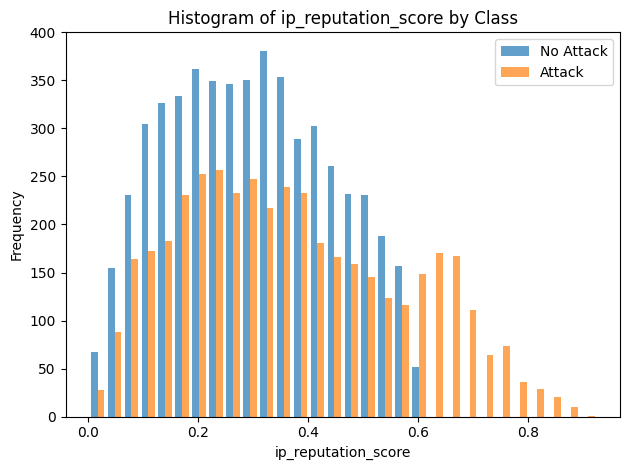

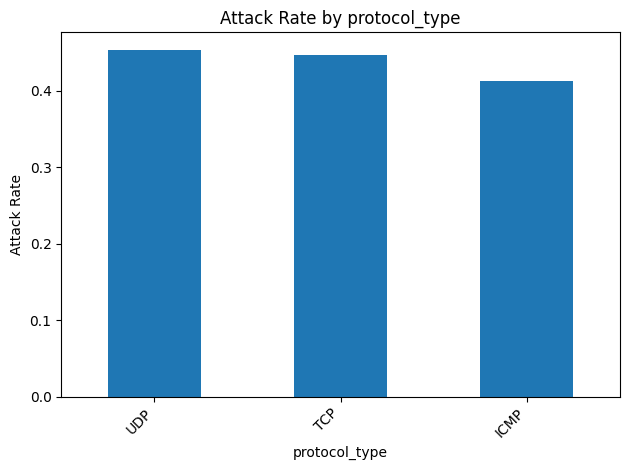

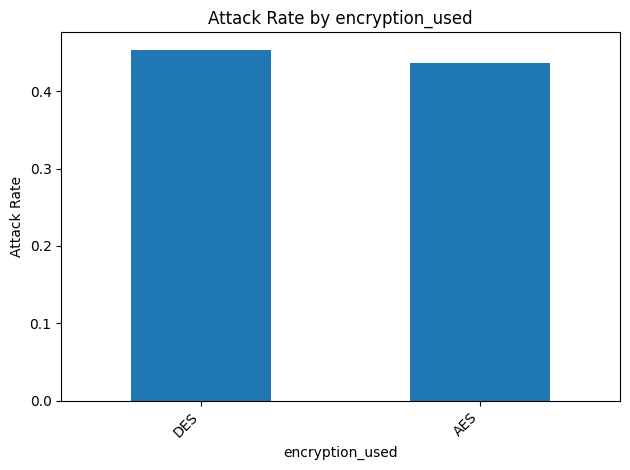

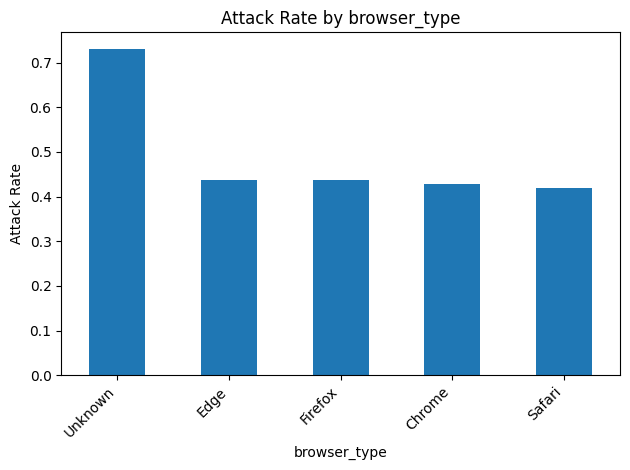


EDA figures saved to: /content/eda_figures

[2] JUSTIFICATION OF CHOSEN TECHNIQUES
------------------------------------------------------------
* KNN: simple non-parametric baseline; sensitive to scaling (good to demonstrate effect).
* Decision Tree: interpretable rules; handles mixed data; useful feature importances.
* Random Forest: robust ensemble; strong for tabular data; reduces variance vs a single tree.

=== Model Performance: Baseline vs Enhanced ===
        Model    Setup  Accuracy  Precision  Recall     F1  ROC_AUC
          KNN Baseline    0.8187     0.9251  0.6469 0.7614   0.8545
Decision Tree Baseline    0.8117     0.7901  0.7883 0.7892   0.8094
Random Forest Baseline    0.8819     0.9856  0.7469 0.8498   0.8755
          KNN Enhanced    0.5171     0.4512  0.3688 0.4058   0.5124
Decision Tree Enhanced    0.8711     0.9401  0.7602 0.8406   0.8676
Random Forest Enhanced    0.8847     0.9927  0.7477 0.8529   0.8761

Markdown table for report:

| Model | Setup | Accuracy | Pr

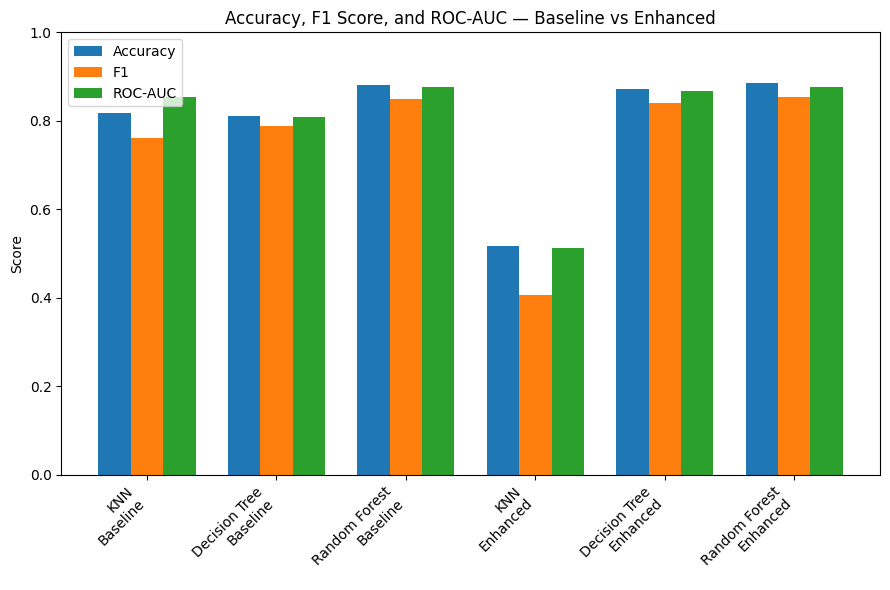

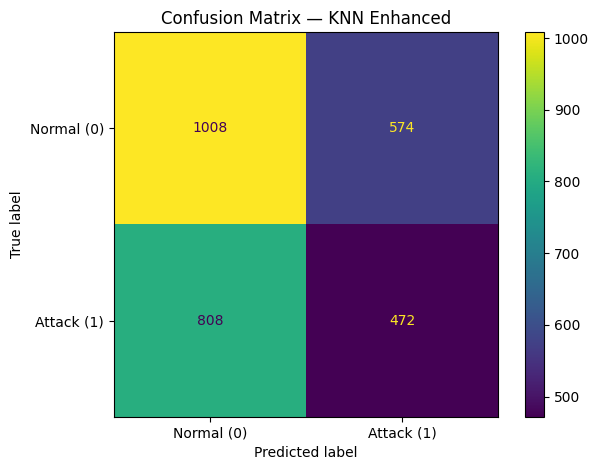

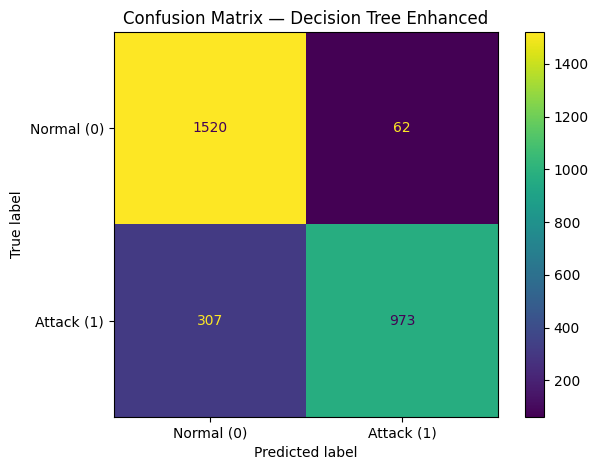

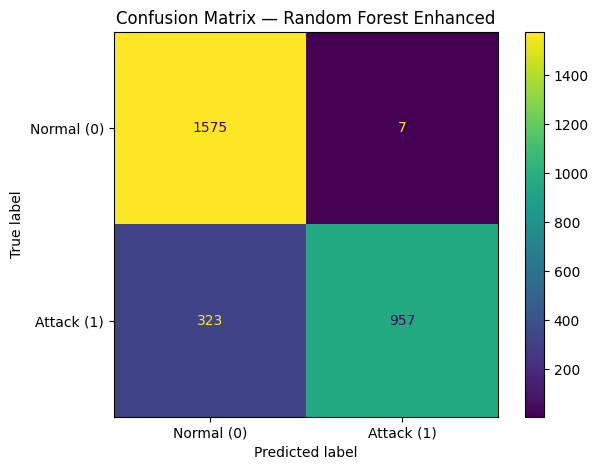

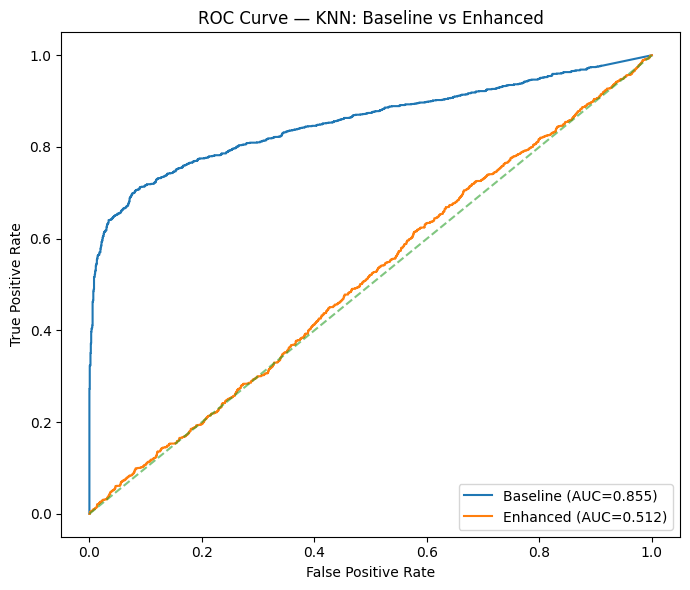

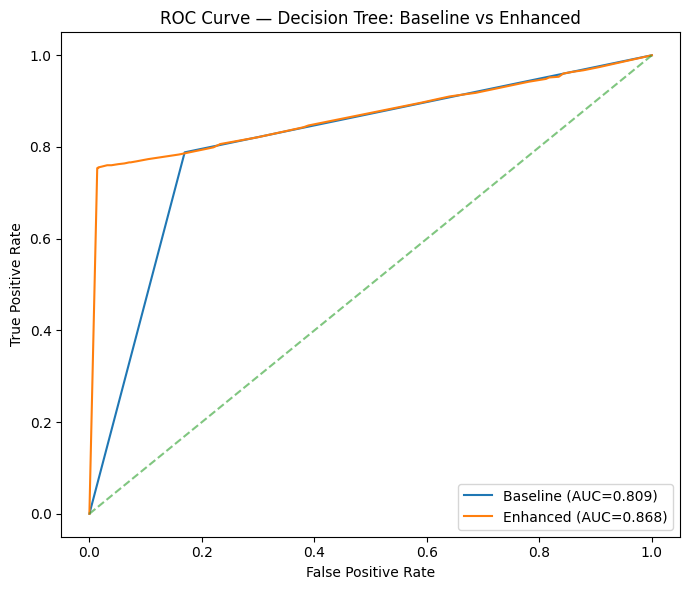

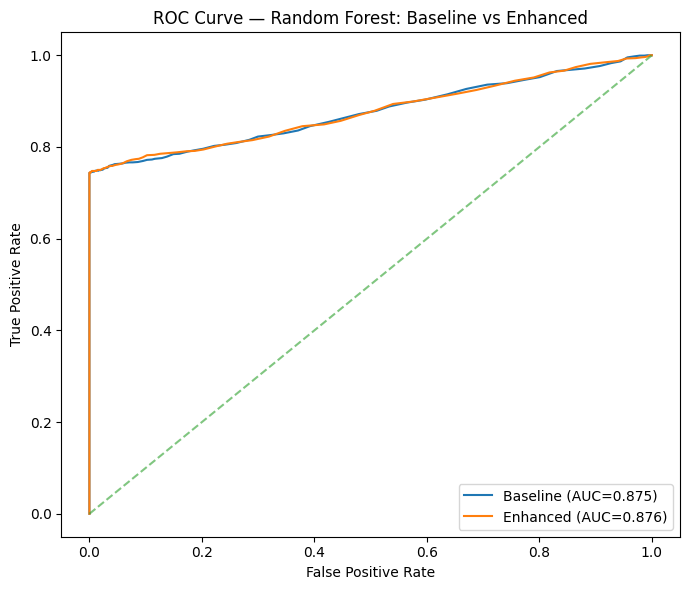

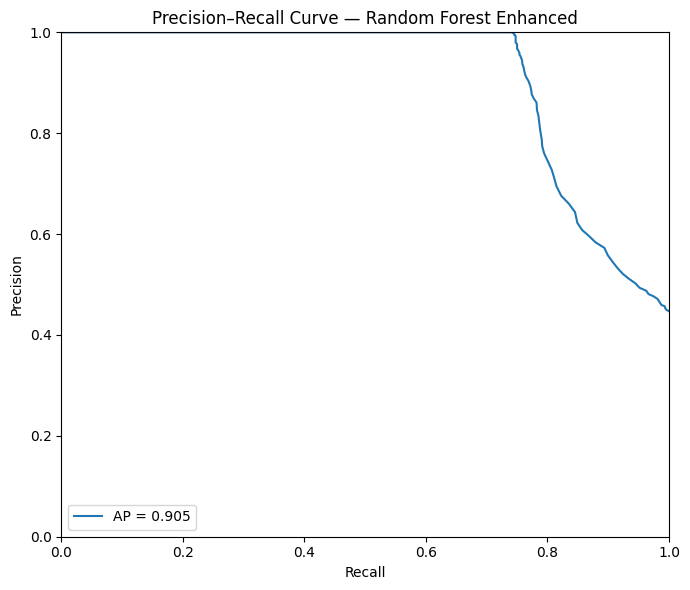

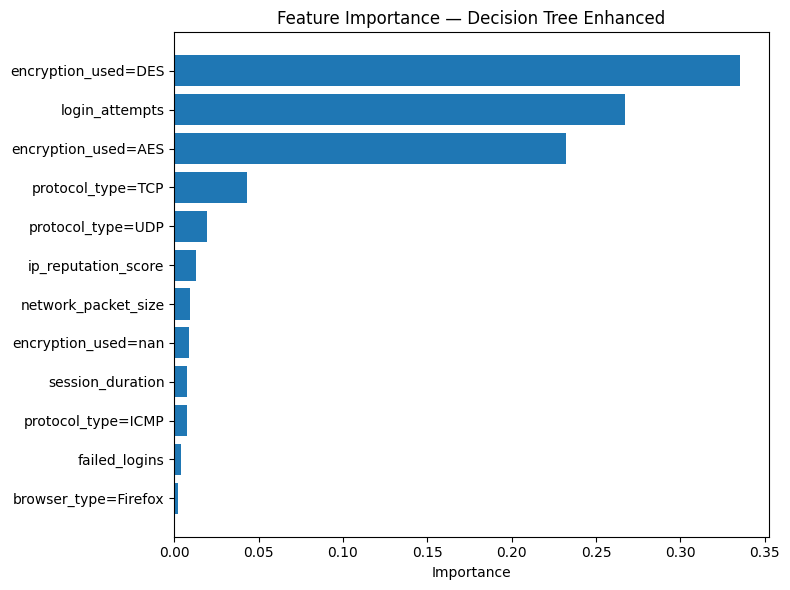

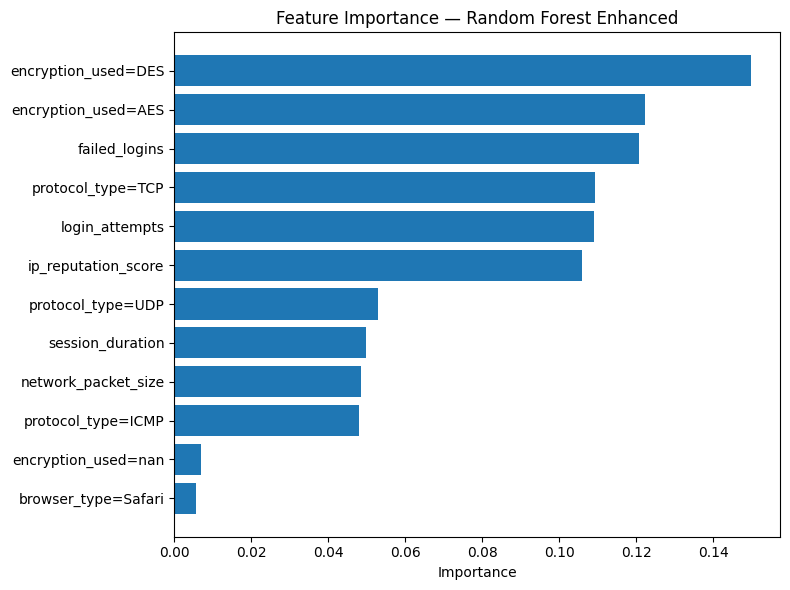


=== Classification Report — KNN (Enhanced) ===
              precision    recall  f1-score   support

  Normal (0)       0.56      0.64      0.59      1582
  Attack (1)       0.45      0.37      0.41      1280

    accuracy                           0.52      2862
   macro avg       0.50      0.50      0.50      2862
weighted avg       0.51      0.52      0.51      2862


=== Classification Report — Decision Tree (Enhanced) ===
              precision    recall  f1-score   support

  Normal (0)       0.83      0.96      0.89      1582
  Attack (1)       0.94      0.76      0.84      1280

    accuracy                           0.87      2862
   macro avg       0.89      0.86      0.87      2862
weighted avg       0.88      0.87      0.87      2862


=== Classification Report — Random Forest (Enhanced) ===
              precision    recall  f1-score   support

  Normal (0)       0.83      1.00      0.91      1582
  Attack (1)       0.99      0.75      0.85      1280

    accuracy      

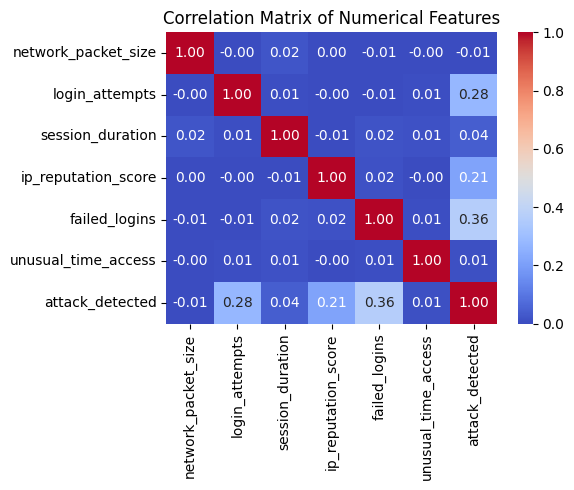

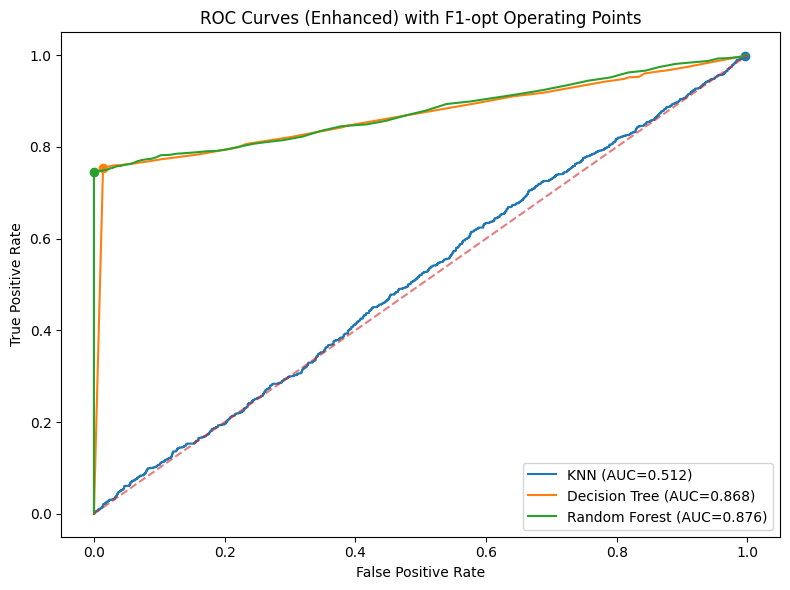

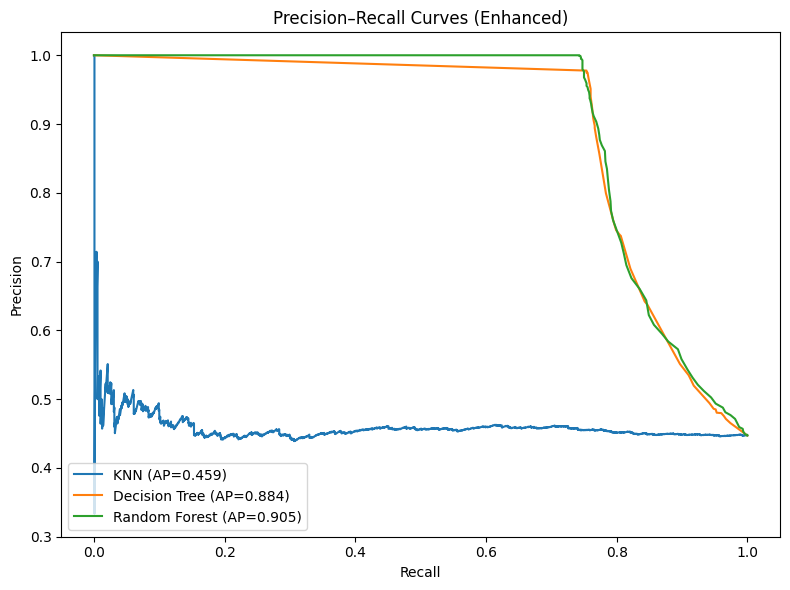

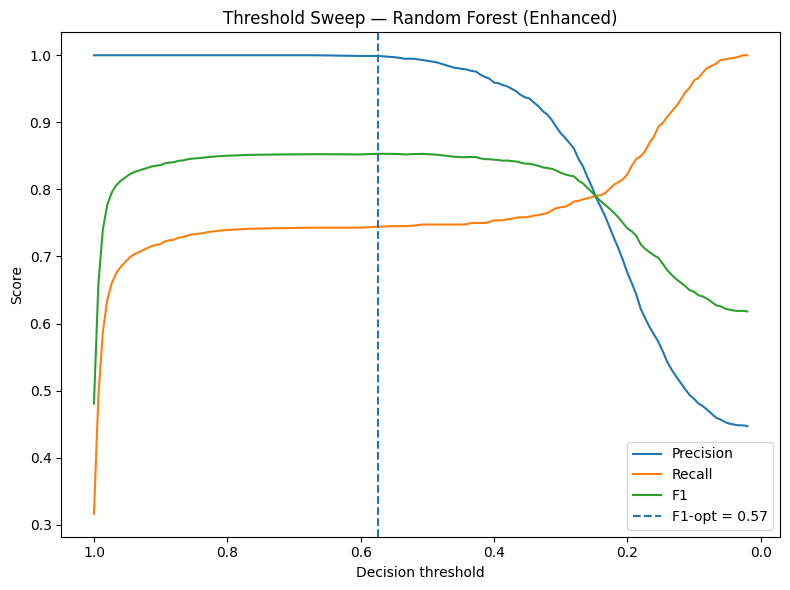

<Figure size 640x480 with 0 Axes>

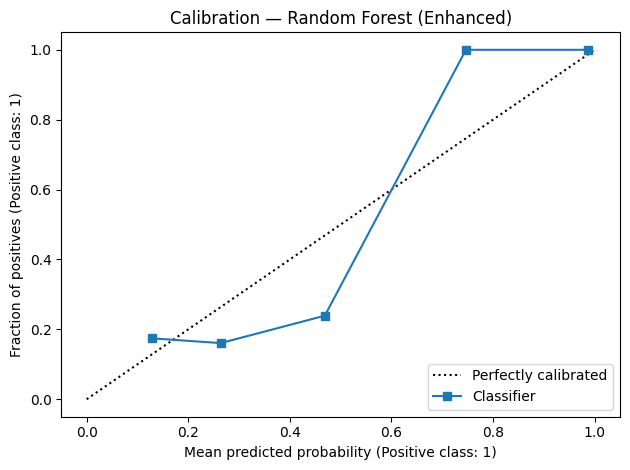

Saved figures to: /content/section5_figures


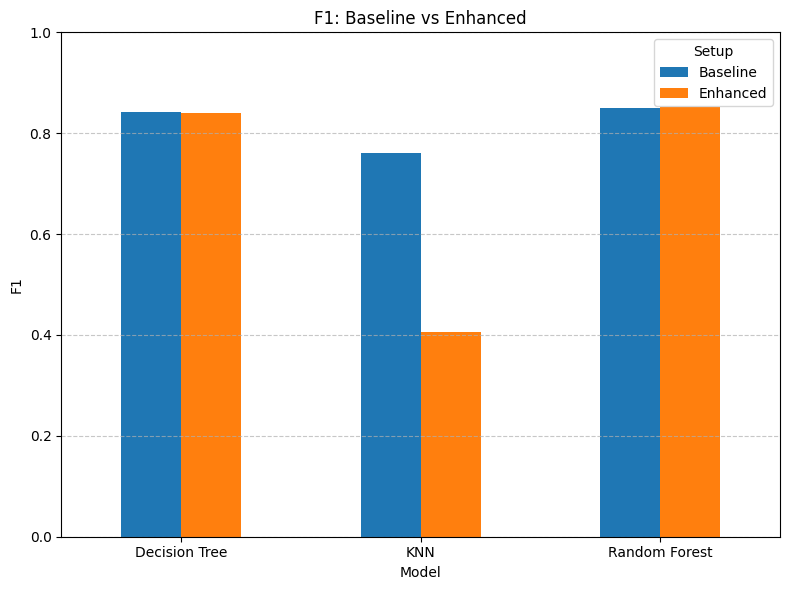

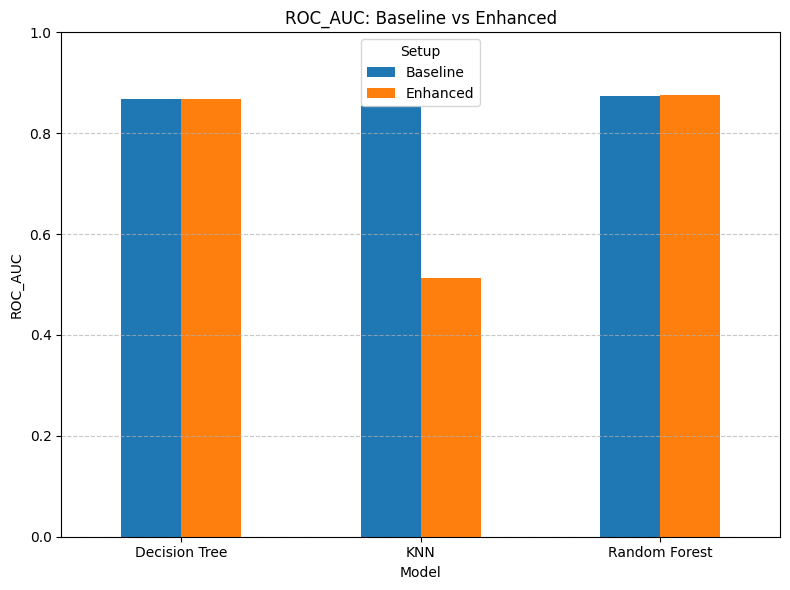

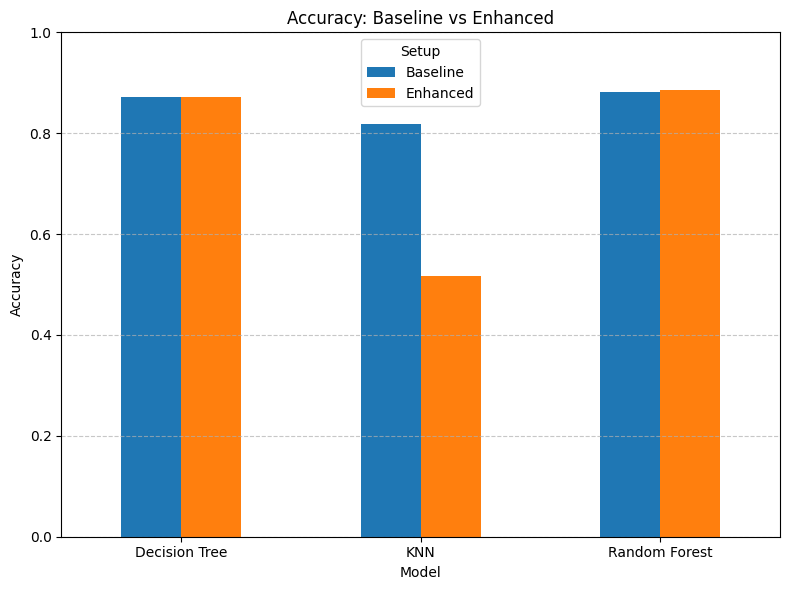

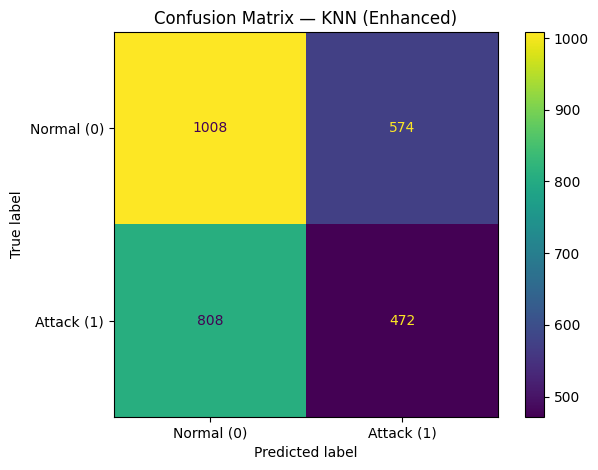

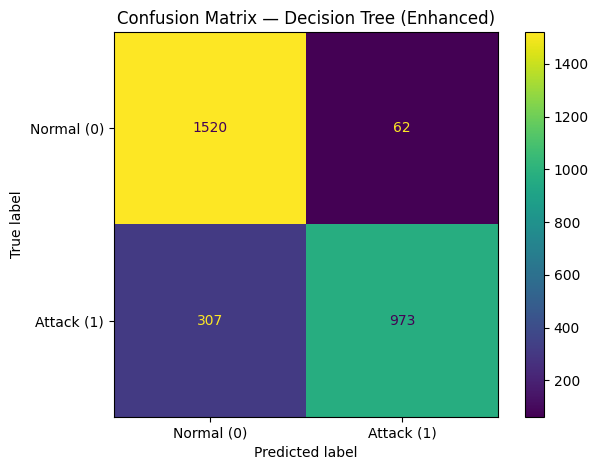

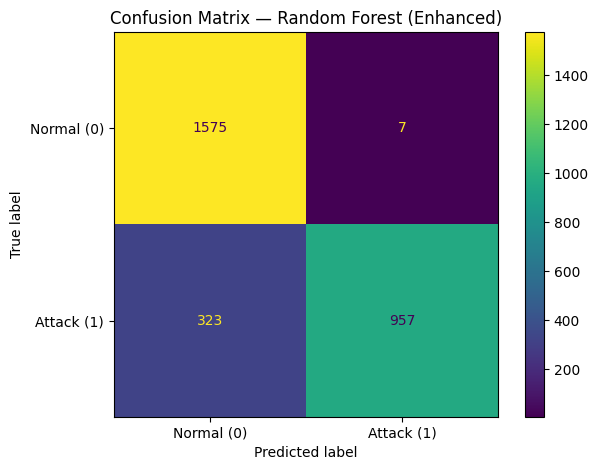

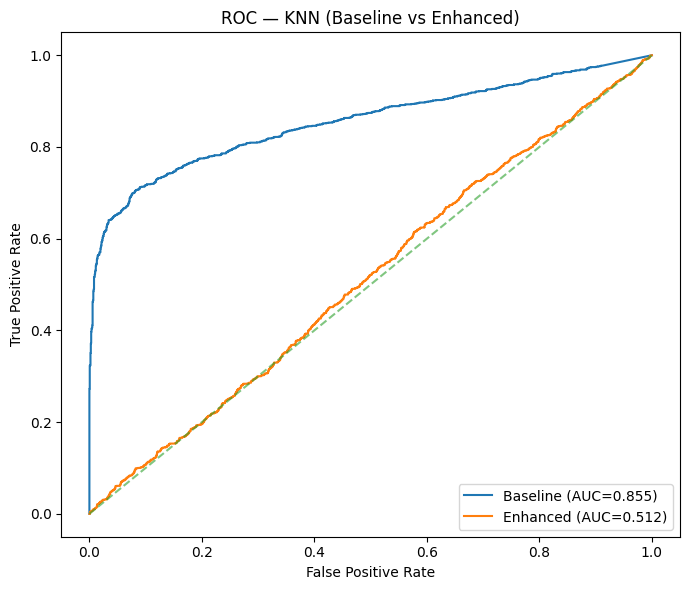

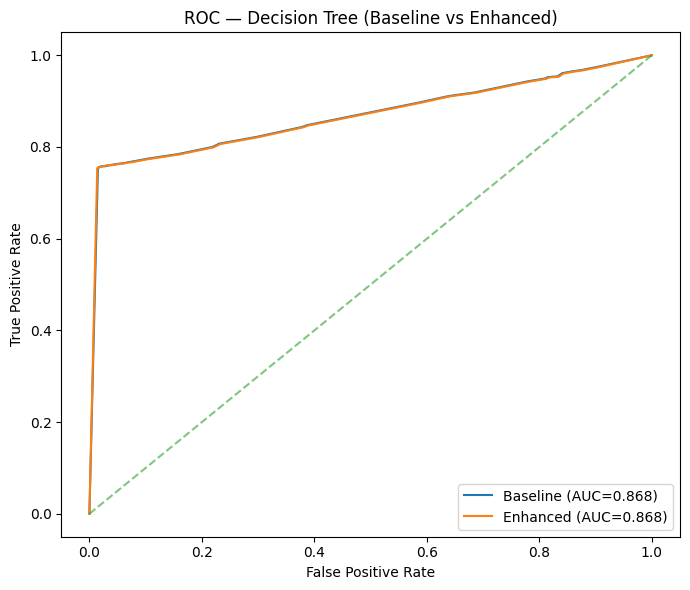

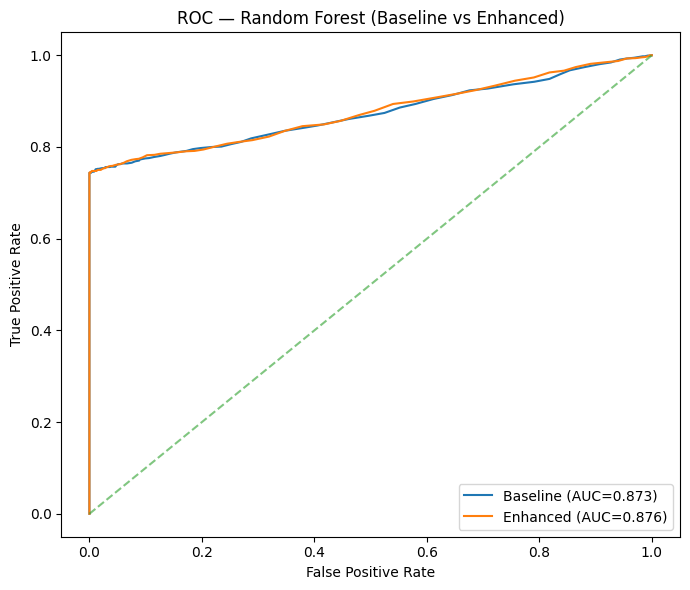

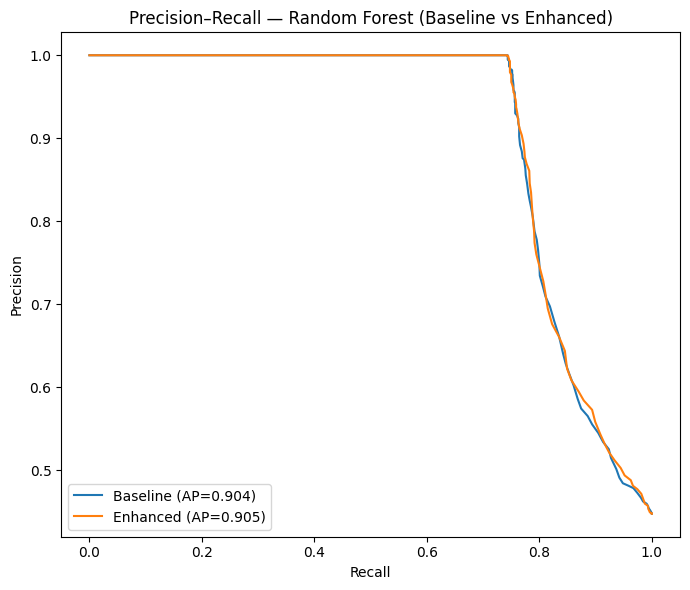

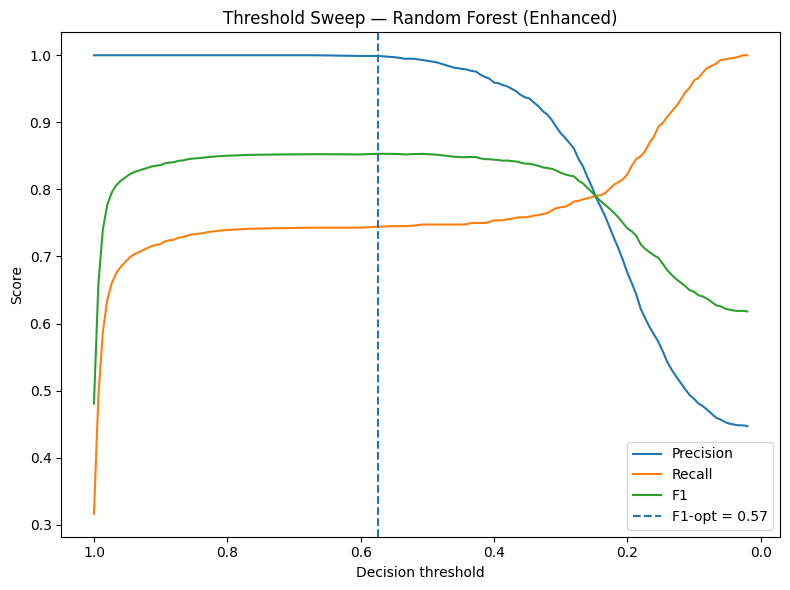

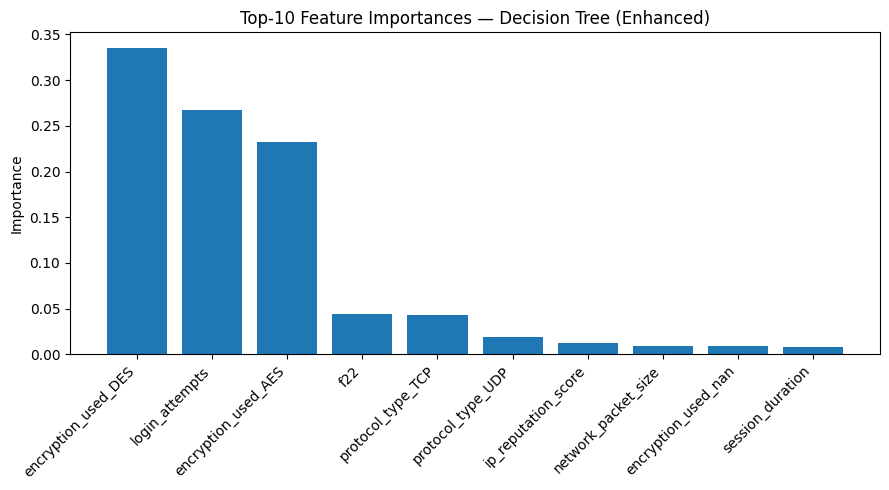

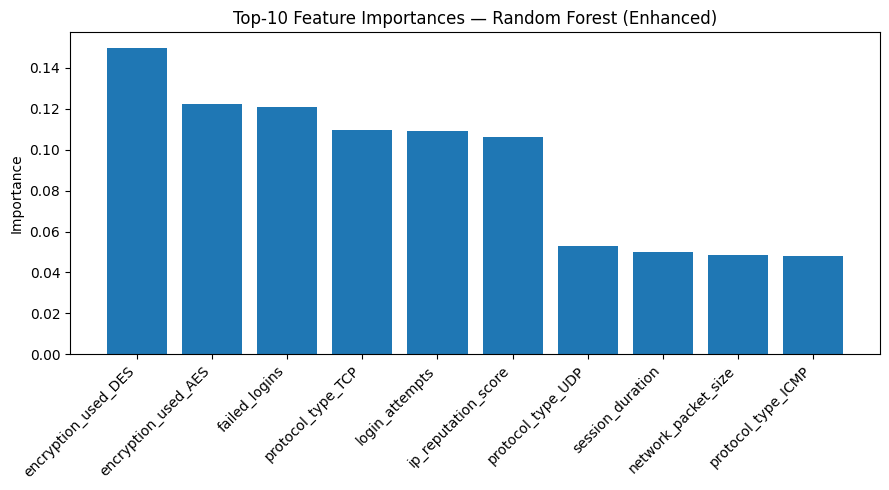


Saved artefacts:
 - model_performance_baseline_vs_enhanced.csv
 - Section6_Timings.csv
 - section6_figures/: ['Accuracy_F1_ROC_Comparison.png', 'CM_DecisionTree_Enhanced.png', 'CM_KNN_Enhanced.png', 'CM_RandomForest_Enhanced.png', 'FI_DT_Enhanced.png', 'FI_DecisionTree_Enhanced_Top10.png', 'FI_RF_Enhanced.png', 'FI_RandomForest_Enhanced_Top10.png', 'PR_RF_Enhanced.png', 'PR_RandomForest_Baseline_vs_Enhanced.png', 'ROC_DecisionTree_Baseline_vs_Enhanced.png', 'ROC_KNN_Baseline_vs_Enhanced.png', 'ROC_RandomForest_Baseline_vs_Enhanced.png', 'S5_Threshold_Sweep_RandomForest_Enhanced.png', 'S6_Accuracy_Comparison.png', 'S6_F1_Comparison.png', 'S6_ROC_AUC_Comparison.png']


In [2]:
# ============================================
# Coursework: EDA + Baseline vs Enhanced (Clean & Annotated)
# Google Colab / Jupyter compatible
# ============================================

# ---------- 0) Environment & Imports ----------
import os, sys, subprocess
def ensure(pkgs):
    for pkg in pkgs:
        try:
            __import__(pkg)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

ensure(["pandas", "numpy", "matplotlib", "sklearn"])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# ============================================
# Helper: robust CSV path discovery (Colab/Jupyter)
# ============================================
def find_csv(name="Cybersecurity Intrusion Detection.csv"):
    candidates = [
        name,
        f"/content/{name}",
        f"/mnt/data/{name}",
        str(Path.cwd() / name),
    ]
    for c in candidates:
        if Path(c).is_file():
            return c
    raise FileNotFoundError(f"Could not find '{name}'. Tried: {candidates}")

CSV_PATH = find_csv("Cybersecurity Intrusion Detection.csv")

# ============================================
# 1) Dataset Description & Exploratory Analysis (size, format, key features)
# ============================================

df = pd.read_csv(CSV_PATH)
target_col = "attack_detected"

print("\n[1] DATASET DESCRIPTION & EXPLORATORY ANALYSIS")
print("-" * 60)
print(f"CSV: {CSV_PATH}")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())
print("\nHead(5):\n", df.head(5))
if target_col in df.columns:
    print("\nTarget distribution (proportions):")
    print(df[target_col].value_counts(normalize=True).rename("proportion").round(3))

# --- EDA Figures 1–9 (kept exactly as you named them) ---
eda_dir = Path("eda_figures")
eda_dir.mkdir(exist_ok=True)

# Figure 1: Attack vs Non-Attack (pie)
class_counts = df[target_col].value_counts().sort_index()
plt.figure()
plt.pie(class_counts, labels=["No Attack", "Attack"], autopct="%1.1f%%", startangle=90)
plt.title("Attack vs Non-Attack Session Distribution")
plt.tight_layout()
plt.savefig(eda_dir / "Figure_1_Attack_vs_NonAttack_Distribution.png", dpi=300)
plt.show()

# Figure 2: Attack vs Non-Attack (bar counts)
plt.figure()
class_counts.plot(kind="bar")
plt.title("Attack vs Non-Attack (Counts)")
plt.xlabel("Class"); plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(eda_dir / "Figure_2_Attack_vs_NonAttack_Counts.png", dpi=300)
plt.show()

# Helper: histograms by class
def hist_by_class(frame, feature, bins=30, fig_num=None):
    s0 = frame[frame[target_col] == 0][feature].dropna()
    s1 = frame[frame[target_col] == 1][feature].dropna()
    plt.figure()
    plt.hist([s0, s1], bins=bins, label=["No Attack", "Attack"], alpha=0.7)
    plt.title(f"Histogram of {feature} by Class")
    plt.xlabel(feature); plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.savefig(eda_dir / f"Figure_{fig_num}_Histogram_{feature}.png", dpi=300)
    plt.show()

# Figures 3–6: numeric histograms (edit if you prefer others)
hist_by_class(df, "network_packet_size", fig_num=3)
hist_by_class(df, "login_attempts", fig_num=4)
hist_by_class(df, "failed_logins", fig_num=5)
hist_by_class(df, "ip_reputation_score", fig_num=6)

# Helper: categorical attack rates
def cat_attack_rate(frame, feature, fig_num=None):
    rates = frame.groupby(feature)[target_col].mean().sort_values(ascending=False)
    plt.figure()
    rates.plot(kind="bar")
    plt.title(f"Attack Rate by {feature}")
    plt.xlabel(feature); plt.ylabel("Attack Rate")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(eda_dir / f"Figure_{fig_num}_AttackRate_{feature}.png", dpi=300)
    plt.show()

# Figures 7–9: categorical attack rates
cat_attack_rate(df, "protocol_type", fig_num=7)
cat_attack_rate(df, "encryption_used", fig_num=8)
cat_attack_rate(df, "browser_type", fig_num=9)

print(f"\nEDA figures saved to: {eda_dir.resolve()}")


# ============================================
# 2) Justification chosen technique (brief, printed)
# ============================================
print("\n[2] JUSTIFICATION OF CHOSEN TECHNIQUES")
print("-" * 60)
print("* KNN: simple non-parametric baseline; sensitive to scaling (good to demonstrate effect).")
print("* Decision Tree: interpretable rules; handles mixed data; useful feature importances.")
print("* Random Forest: robust ensemble; strong for tabular data; reduces variance vs a single tree.")


# ============================================
# 3) Implementation of the Chosen Techniques
#    Baseline vs Enhanced pipelines
# ============================================

# Prepare X/y
id_cols = [c for c in df.columns if "id" in c.lower()]
X = df.drop(columns=id_cols + [target_col])
y = df[target_col].astype(int)

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Enhanced numeric pre-step: IQR outlier clipper
class IQRClipper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.bounds_ = {}
    def fit(self, X, y=None):
        Xn = pd.DataFrame(X, columns=self.columns)
        for c in self.columns:
            q1 = np.nanpercentile(Xn[c], 25)
            q3 = np.nanpercentile(Xn[c], 75)
            iqr = q3 - q1
            self.bounds_[c] = (q1 - 1.5*iqr, q3 + 1.5*iqr)
        return self
    def transform(self, X):
        Xn = pd.DataFrame(X, columns=self.columns)
        for c in self.columns:
            lo, up = self.bounds_[c]
            Xn[c] = Xn[c].clip(lo, up)
        return Xn.values

# Baseline preprocessor: scale nums + OHE cats
baseline_pre = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

# Enhanced preprocessor: clip outliers -> scale nums + OHE cats
enhanced_pre = ColumnTransformer([
    ("clip", IQRClipper(numeric_cols), numeric_cols),
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

# Fixed model configs
baseline_models = {
    "KNN": KNeighborsClassifier(n_neighbors=11, weights="distance", p=2),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=150, n_jobs=-1)
}
enhanced_models = {
    "KNN": KNeighborsClassifier(n_neighbors=11, weights="distance", p=2),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=12, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(
        random_state=42, n_estimators=150, max_depth=None, n_jobs=-1, class_weight="balanced_subsample"
    )
}

# Split once (reproducible & stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

def evaluate(preprocessor, models_dict, label):
    rows = []
    store = {}  # model_name -> dict(clf, y_pred, y_prob)
    for name, clf in models_dict.items():
        pipe = Pipeline([("pre", preprocessor), ("clf", clf)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        # probs for ROC/PR if available
        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            y_prob = pipe.predict_proba(X_test)[:, 1]
        else:
            y_prob = None  # keep None if not supported
        # Metrics
        auc_val = roc_auc_score(y_test, y_prob) if y_prob is not None else roc_auc_score(y_test, y_pred)
        rows.append({
            "Model": name, "Setup": label,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1": f1_score(y_test, y_pred, zero_division=0),
            "ROC_AUC": auc_val
        })
        store[name] = {"pipe": pipe, "y_pred": y_pred, "y_prob": y_prob}
    return pd.DataFrame(rows), store

baseline_results, baseline_store = evaluate(baseline_pre, baseline_models, "Baseline")
enhanced_results, enhanced_store = evaluate(enhanced_pre, enhanced_models, "Enhanced")
results = pd.concat([baseline_results, enhanced_results], ignore_index=True).round(4)

print("\n=== Model Performance: Baseline vs Enhanced ===")
print(results.to_string(index=False))

# Save CSV + Markdown table
results.to_csv("model_performance_baseline_vs_enhanced.csv", index=False)

def to_markdown_table(df):
    cols = df.columns.tolist()
    header = "| " + " | ".join(cols) + " |"
    sep = "| " + " | ".join(["---"]*len(cols)) + " |"
    rows = ["| " + " | ".join(map(str, row)) + " |" for row in df.values]
    return "\n".join([header, sep] + rows)

print("\nMarkdown table for report:\n")
print(to_markdown_table(results))


# ============================================
# 4) Evaluation Metrics Selection & Rationale (printed)
# ============================================
print("\n[4] EVALUATION METRICS SELECTION & RATIONALE")
print("-" * 60)
print("* Accuracy — overall correctness.")
print("* Precision/Recall/F1 — balance false positives (alerts) vs false negatives (missed attacks).")
print("* ROC-AUC — threshold-independent separability; good for comparing classifiers.")


# ============================================
# 5) Discussion of Visualised Results + Figures (Section 6)
#    - Combined Accuracy/F1/ROC-AUC bar
#    - Confusion matrices (Enhanced)
#    - ROC curves (Baseline vs Enhanced) per model
#    - Precision–Recall (RF Enhanced)
#    - Feature Importances (DT & RF Enhanced)
# ============================================

sec6_dir = Path("section6_figures"); sec6_dir.mkdir(exist_ok=True)

# Figure: Combined Accuracy/F1/ROC-AUC for all models (Baseline+Enhanced)
def save_combined_bar(df, path):
    labels = [f"{m}\n{s}" for m, s in zip(df["Model"], df["Setup"])]
    x = np.arange(len(labels)); w = 0.25
    plt.figure(figsize=(9,6))
    plt.bar(x - w, df["Accuracy"], width=w, label="Accuracy")
    plt.bar(x,       df["F1"],      width=w, label="F1")
    plt.bar(x + w,   df["ROC_AUC"], width=w, label="ROC-AUC")
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Score"); plt.ylim(0, 1)
    plt.title("Accuracy, F1 Score, and ROC-AUC — Baseline vs Enhanced")
    plt.legend(); plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()

save_combined_bar(results, sec6_dir / "Accuracy_F1_ROC_Comparison.png")

# Confusion matrices — Enhanced only (3 figs)
for model in ["KNN", "Decision Tree", "Random Forest"]:
    y_pred = enhanced_store[model]["y_pred"]
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Normal (0)", "Attack (1)"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {model} Enhanced")
    plt.tight_layout()
    plt.savefig(sec6_dir / f"CM_{model.replace(' ', '')}_Enhanced.png", dpi=300, bbox_inches="tight")
    plt.show()

# ROC curves — Baseline vs Enhanced (3 figs)
def plot_roc_overlay(model, path):
    plt.figure(figsize=(7,6))
    for label, store in [("Baseline", baseline_store), ("Enhanced", enhanced_store)]:
        y_prob = store[model]["y_prob"]
        if y_prob is None:
            continue
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'--', alpha=0.6)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {model}: Baseline vs Enhanced")
    plt.legend(loc="lower right"); plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()

for m in ["KNN", "Decision Tree", "Random Forest"]:
    plot_roc_overlay(m, sec6_dir / f"ROC_{m.replace(' ', '')}_Baseline_vs_Enhanced.png")

# Precision–Recall — RF Enhanced (as per your narrative)
rf_prob = enhanced_store["Random Forest"]["y_prob"]
if rf_prob is not None:
    prec, rec, _ = precision_recall_curve(y_test, rf_prob)
    ap = average_precision_score(y_test, rf_prob)
    plt.figure(figsize=(7,6))
    plt.plot(rec, prec, label=f"AP = {ap:.3f}")
    plt.xlim([0,1]); plt.ylim([0,1])
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curve — Random Forest Enhanced")
    plt.legend(loc="lower left"); plt.tight_layout()
    plt.savefig(sec6_dir / "PR_RF_Enhanced.png", dpi=300, bbox_inches="tight")
    plt.show()

# Feature importances — DT & RF Enhanced
# (Note: after OHE, feature names are expanded; we’ll reconstruct from the pipeline)
def get_ohe_feature_names(pipe, numeric_cols, categorical_cols):
    pre: ColumnTransformer = pipe.named_steps["pre"]
    # numeric first (same names)
    names = list(numeric_cols)
    # then categorical expanded
    ohe = pre.named_transformers_["cat"]
    if hasattr(ohe, "categories_"):
        for col, cats in zip(categorical_cols, ohe.categories_):
            names.extend([f"{col}={c}" for c in cats])
    return names

def plot_top_importances(model_name, store_dict, path, top_k=12):
    pipe = store_dict[model_name]["pipe"]
    clf = pipe.named_steps["clf"]
    if not hasattr(clf, "feature_importances_"):
        return
    names = get_ohe_feature_names(pipe, numeric_cols, categorical_cols)
    imps = clf.feature_importances_
    k = min(len(names), len(imps))
    s = pd.Series(imps[:k], index=names[:k]).sort_values(ascending=False).head(top_k)
    plt.figure(figsize=(8,6))
    plt.barh(s.index[::-1], s.values[::-1])
    plt.xlabel("Importance"); plt.title(f"Feature Importance — {model_name} Enhanced")
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()

plot_top_importances("Decision Tree", enhanced_store, sec6_dir / "FI_DT_Enhanced.png", top_k=12)
plot_top_importances("Random Forest", enhanced_store, sec6_dir / "FI_RF_Enhanced.png", top_k=12)

# Classification reports (print + save TXT)
for model in ["KNN", "Decision Tree", "Random Forest"]:
    rep = classification_report(y_test, enhanced_store[model]["y_pred"],
                                target_names=["Normal (0)", "Attack (1)"])
    print(f"\n=== Classification Report — {model} (Enhanced) ===\n{rep}")
    with open(f"CR_{model.replace(' ', '')}_Enhanced.txt", "w") as f:
        f.write(rep)

print("\nSaved files include:")
print(f"- {sec6_dir}/Accuracy_F1_ROC_Comparison.png")
print(f"- {sec6_dir}/CM_*.png (3 Enhanced confusion matrices)")
print(f"- {sec6_dir}/ROC_*.png (3 ROC overlays per model)")
print(f"- {sec6_dir}/PR_RF_Enhanced.png")
print(f"- {sec6_dir}/FI_*.png (DT & RF Enhanced)")
print("- CR_*.txt (Enhanced classification reports)")
print("- model_performance_baseline_vs_enhanced.csv (metrics table)")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path

def make_feature_summary_plots(df: pd.DataFrame, outdir="eda_figures",
                               exclude=("session_id", "attack_detected")):
    out = Path(outdir); out.mkdir(exist_ok=True)

    # Split features
    cols = [c for c in df.columns if c not in exclude]
    num_cols = df[cols].select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in cols if c not in num_cols]

    # ---------- Numeric summary (min, Q1, median, Q3, max) ----------
    num_stats = []
    for c in num_cols:
        s = df[c].dropna()
        if s.empty:
            continue
        num_stats.append({
            "Feature": c,
            "Min": s.min(),
            "Q1": s.quantile(0.25),
            "Median": s.quantile(0.50),
            "Q3": s.quantile(0.75),
            "Max": s.max()
        })
    num_df = pd.DataFrame(num_stats)

    # Normalized five-number summary plot (per-feature 0..1)
    if not num_df.empty:
        fig, ax = plt.subplots(figsize=(9, 5))
        eps = 1e-12
        def norm(v, a, b): return (v - a) / (b - a + eps)
        y = np.arange(len(num_df))[::-1]; h = 0.28

        for i, r in num_df.iterrows():
            a, q1, m, q3, b = r["Min"], r["Q1"], r["Median"], r["Q3"], r["Max"]
            a_, q1_, m_, q3_, b_ = [norm(v, a, b) for v in (a, q1, m, q3, b)]
            yy = y[i]
            ax.hlines(yy, a_, b_, lw=2)                            # whisker
            ax.barh(yy, q3_ - q1_, left=q1_, height=h, alpha=0.6)  # IQR
            ax.plot([m_, m_], [yy - h, yy + h], lw=2)              # median

        ax.set_yticks(y); ax.set_yticklabels(num_df["Feature"])
        ax.set_xlabel("Normalized value (0 = min, 1 = max)")
        ax.set_title("Numeric feature summary (min–max, IQR, median)")
        ax.legend([Patch(alpha=0.6)], ["IQR (Q1–Q3)"], loc="lower right")
        plt.tight_layout()
        plt.savefig(out / "FeatureSummary_Numeric.png", dpi=300, bbox_inches="tight")
        plt.show()

    # ---------- Categorical summary (cardinality, top share) ----------
    if cat_cols:
        cat_rows = []
        for c in cat_cols:
            vc = df[c].value_counts(dropna=True)
            if vc.empty:
                continue
            top = vc.index[0]; freq = int(vc.iloc[0]); cnt = int(df[c].notna().sum())
            cat_rows.append({"Feature": c, "Unique": int(df[c].nunique()), "Top": str(top),
                             "Freq": freq, "Count": cnt, "TopShare": freq / max(cnt, 1)})
        cat_df = pd.DataFrame(cat_rows)
        if not cat_df.empty:
            fig, axes = plt.subplots(1, 2, figsize=(11, 4))

            # Unique categories
            axes[0].bar(cat_df["Feature"], cat_df["Unique"])
            axes[0].set_title("Categorical cardinality (Unique)")
            axes[0].set_ylabel("Unique categories")
            axes[0].tick_params(axis='x', labelrotation=45)
            plt.setp(axes[0].get_xticklabels(), ha='right')

            # Top category share
            axes[1].bar(cat_df["Feature"], cat_df["TopShare"])
            axes[1].set_ylim(0, 1)
            axes[1].set_title("Top category share (Freq / Count)")
            axes[1].set_ylabel("Proportion of rows")
            axes[1].tick_params(axis='x', labelrotation=45)
            plt.setp(axes[1].get_xticklabels(), ha='right')

            plt.suptitle("Categorical feature summary", y=1.02)
            plt.tight_layout()
            plt.savefig(out / "FeatureSummary_Categorical.png", dpi=300, bbox_inches="tight")
            plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path

def make_feature_summary_plots(df: pd.DataFrame, outdir="eda_figures",
                               exclude=("session_id", "attack_detected"),
                               verbose=True):
    saved = []
    out = Path(outdir); out.mkdir(parents=True, exist_ok=True)
    if verbose:
        print(f"[cwd] {Path.cwd().resolve()}")
        print(f"[outdir] {out.resolve()}")

    # Exclude only columns that exist
    exclude = [c for c in exclude if c in df.columns]
    cols = [c for c in df.columns if c not in exclude]
    num_cols = df[cols].select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in cols if c not in num_cols]
    if verbose:
        print(f"[columns] numeric={len(num_cols)} {num_cols}")
        print(f"[columns] categorical={len(cat_cols)} {cat_cols}")

    # ---------- Numeric summary ----------
    num_stats = []
    for c in num_cols:
        s = df[c].dropna()
        if s.empty:
            continue
        num_stats.append({
            "Feature": c,
            "Min": s.min(),
            "Q1": s.quantile(0.25),
            "Median": s.quantile(0.50),
            "Q3": s.quantile(0.75),
            "Max": s.max()
        })
    num_df = pd.DataFrame(num_stats)

    if not num_df.empty:
        fig, ax = plt.subplots(figsize=(9, 5))
        eps = 1e-12
        def norm(v, a, b): return (v - a) / (b - a + eps)
        y = np.arange(len(num_df))[::-1]; h = 0.28

        for i, r in num_df.iterrows():
            a, q1, m, q3, b = r["Min"], r["Q1"], r["Median"], r["Q3"], r["Max"]
            a_, q1_, m_, q3_, b_ = [norm(v, a, b) for v in (a, q1, m, q3, b)]
            yy = y[i]
            ax.hlines(yy, a_, b_, lw=2)                            # whisker
            ax.barh(yy, q3_ - q1_, left=q1_, height=h, alpha=0.6)  # IQR
            ax.plot([m_, m_], [yy - h, yy + h], lw=2)              # median

        ax.set_yticks(y); ax.set_yticklabels(num_df["Feature"])
        ax.set_xlabel("Normalized value (0 = min, 1 = max)")
        ax.set_title("Numeric feature summary (min–max, IQR, median)")
        ax.legend([Patch(alpha=0.6)], ["IQR (Q1–Q3)"], loc="lower right")
        fig.tight_layout()
        fn = out / "FeatureSummary_Numeric.png"
        fig.savefig(fn, dpi=300, bbox_inches="tight")
        plt.close(fig)
        saved.append(str(fn.resolve()))
        if verbose: print(f"[saved] {fn.resolve()}")
    else:
        if verbose: print("[skip] no numeric features found")

    # ---------- Categorical summary ----------
    if cat_cols:
        cat_rows = []
        for c in cat_cols:
            vc = df[c].value_counts(dropna=True)
            if vc.empty:
                continue
            top = vc.index[0]; freq = int(vc.iloc[0]); cnt = int(df[c].notna().sum())
            cat_rows.append({"Feature": c, "Unique": int(df[c].nunique()), "Top": str(top),
                             "Freq": freq, "Count": cnt, "TopShare": freq / max(cnt, 1)})
        cat_df = pd.DataFrame(cat_rows)

        if not cat_df.empty:
            fig, axes = plt.subplots(1, 2, figsize=(11, 4))
            axes[0].bar(cat_df["Feature"], cat_df["Unique"])
            axes[0].set_title("Categorical cardinality (Unique)")
            axes[0].set_ylabel("Unique categories")
            axes[0].tick_params(axis='x', labelrotation=45)
            plt.setp(axes[0].get_xticklabels(), ha='right')

            axes[1].bar(cat_df["Feature"], cat_df["TopShare"])
            axes[1].set_ylim(0, 1)
            axes[1].set_title("Top category share (Freq / Count)")
            axes[1].set_ylabel("Proportion of rows")
            axes[1].tick_params(axis='x', labelrotation=45)
            plt.setp(axes[1].get_xticklabels(), ha='right')

            plt.suptitle("Categorical feature summary", y=1.02)
            fig.tight_layout()
            fn = out / "FeatureSummary_Categorical.png"
            fig.savefig(fn, dpi=300, bbox_inches="tight")
            plt.close(fig)
            saved.append(str(fn.resolve()))
            if verbose: print(f"[saved] {fn.resolve()}")
        else:
            if verbose: print("[skip] categorical features have no valid counts")
    else:
        if verbose: print("[skip] no categorical features found")

    if verbose and not saved:
        print("[note] Nothing saved—check that df has numeric/categorical columns after exclusions.")
    return saved

    import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("Cybersecurity Intrusion Detection.csv")

# Select only numerical features
numeric_features = df.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_matrix,
    annot=True,         # show correlation values
    fmt=".2f",          # decimal format
    cmap='coolwarm',    # color scheme
    vmin=0, vmax=1      # color scale from 0 to 1
)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

# === Section 5: methodology figures (Enhanced models) ===
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix
)
from sklearn.calibration import CalibrationDisplay

outdir = Path("section5_figures"); outdir.mkdir(exist_ok=True)

def f1_opt_threshold(y_true, y_score):
    p, r, thr = precision_recall_curve(y_true, y_score)
    f1 = 2 * p[:-1] * r[:-1] / (p[:-1] + r[:-1] + 1e-12)
    i = int(np.argmax(f1))
    return float(thr[i]), float(p[i]), float(r[i]), float(f1[i])

# 1) ROC curves (Enhanced) with F1-opt operating point
plt.figure(figsize=(8,6))
for model, entry in enhanced_store.items():
    y_prob = entry.get("y_prob")
    if y_prob is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model} (AUC={auc:.3f})")

    # mark F1-opt point (computed via PR curve)
    thr_opt, prec, rec, f1 = f1_opt_threshold(y_test, y_prob)
    y_hat = (y_prob >= thr_opt).astype(int)
    cm = confusion_matrix(y_test, y_hat)
    # TPR and FPR at that threshold
    tpr_pt = cm[1,1] / (cm[1,1] + cm[1,0] + 1e-12)
    fpr_pt = cm[0,1] / (cm[0,1] + cm[0,0] + 1e-12)
    plt.scatter([fpr_pt], [tpr_pt], marker="o")
plt.plot([0,1],[0,1],'--', alpha=0.6)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Enhanced) with F1-opt Operating Points")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(outdir / "S5_ROC_Enhanced_with_F1opt.png", dpi=300, bbox_inches="tight")
plt.show()

# 2) Precision–Recall curves (Enhanced) with AP in legend
plt.figure(figsize=(8,6))
for model, entry in enhanced_store.items():
    y_prob = entry.get("y_prob")
    if y_prob is None:
        continue
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, label=f"{model} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Enhanced)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig(outdir / "S5_PR_Enhanced.png", dpi=300, bbox_inches="tight")
plt.show()

# 3) Threshold sweep (Precision/Recall/F1 vs threshold) for the best model
best_model = "Random Forest" if "Random Forest" in enhanced_store else list(enhanced_store.keys())[0]
y_prob = enhanced_store[best_model]["y_prob"]

prec, rec, thr = precision_recall_curve(y_test, y_prob)
f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
thr = thr  # already excludes the last PR point

thr_opt, p_opt, r_opt, f1_opt = f1_opt_threshold(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(thr, prec[:-1], label="Precision")
plt.plot(thr, rec[:-1],  label="Recall")
plt.plot(thr, f1,        label="F1")
plt.axvline(thr_opt, linestyle="--", label=f"F1-opt = {thr_opt:.2f}")
plt.gca().invert_xaxis()  # high threshold on left → common in PR plots
plt.xlabel("Decision threshold"); plt.ylabel("Score")
plt.title(f"Threshold Sweep — {best_model} (Enhanced)")
plt.legend()
plt.tight_layout()
plt.savefig(outdir / f"S5_Threshold_Sweep_{best_model.replace(' ','')}_Enhanced.png", dpi=300, bbox_inches="tight")
plt.show()

# 4) Optional: calibration plot for the best model
plt.figure()
CalibrationDisplay.from_predictions(y_test, y_prob)
plt.title(f"Calibration — {best_model} (Enhanced)")
plt.tight_layout()
plt.savefig(outdir / f"S5_Calibration_{best_model.replace(' ','')}_Enhanced.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved figures to:", outdir.resolve())

# ===============================
# SECTION 6 — RESULTS & FIGURES
# End-to-end code cell (Colab/Jupyter)
# ===============================

import os, time, math, pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score, classification_report
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# -----------------------
# 0) Load dataset (robust path)
# -----------------------
def load_df():
    candidates = [
        "/content/Cybersecurity Intrusion Detection.csv",
        "Cybersecurity Intrusion Detection.csv",
        "/mnt/data/Cybersecurity Intrusion Detection.csv",
    ]
    for p in candidates:
        if Path(p).is_file():
            return pd.read_csv(p)
    raise FileNotFoundError("Could not find 'Cybersecurity Intrusion Detection.csv' in common locations.")

df = load_df()
target_col = "attack_detected"
assert target_col in df.columns, f"Target column '{target_col}' not found."

# -----------------------
# 1) Train/Test split + columns
# -----------------------
y = df[target_col].astype(int)
id_cols = [c for c in df.columns if "id" in c.lower()]
X = df.drop(columns=id_cols + [target_col])

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# -----------------------
# 2) Enhanced preprocessor: IQR clipper + scaling + OHE
# -----------------------
class IQRClipper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.bounds_ = {}

    def fit(self, X, y=None):
        Xn = pd.DataFrame(X, columns=self.columns)
        for c in self.columns:
            q1 = np.nanpercentile(Xn[c], 25)
            q3 = np.nanpercentile(Xn[c], 75)
            iqr = q3 - q1
            self.bounds_[c] = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
        return self

    def transform(self, X):
        Xn = pd.DataFrame(X, columns=self.columns)
        for c in self.columns:
            lo, up = self.bounds_[c]
            Xn[c] = Xn[c].clip(lo, up)
        return Xn.values

baseline_pre = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
])

enhanced_pre = ColumnTransformer([
    ("clip", IQRClipper(numeric_cols), numeric_cols),
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
])

# -----------------------
# 3) Models (same as earlier work)
# -----------------------
models = {
    "KNN": KNeighborsClassifier(n_neighbors=11, weights="distance", p=2),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=12, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(
        random_state=42, n_estimators=150, n_jobs=-1, class_weight="balanced_subsample"
    ),
}

# -----------------------
# 4) Evaluate helper
# -----------------------
def evaluate(preprocessor, label):
    rows = []
    store = {}  # per model artifacts for plots
    timings = []

    for name, clf in models.items():
        pipe = Pipeline([("pre", preprocessor), ("clf", clf)])

        t0 = time.time()
        pipe.fit(X_train, y_train)
        fit_t = time.time() - t0

        t1 = time.time()
        y_pred = pipe.predict(X_test)
        pred_t = time.time() - t1

        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            y_prob = pipe.predict_proba(X_test)[:, 1]
        else:
            y_prob = None

        auc_val = roc_auc_score(y_test, y_prob) if y_prob is not None else roc_auc_score(y_test, y_pred)

        rows.append({
            "Model": name,
            "Setup": label,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1": f1_score(y_test, y_pred, zero_division=0),
            "ROC_AUC": auc_val
        })
        store[name] = {"pipe": pipe, "y_pred": y_pred, "y_prob": y_prob}
        timings.append({"Setup": label, "Model": name,
                        "Fit_Time_s": round(fit_t, 4), "Predict_Time_s": round(pred_t, 4)})

    return pd.DataFrame(rows), store, pd.DataFrame(timings)

# -----------------------
# 5) Run both setups
# -----------------------
baseline_results, baseline_store, baseline_timings = evaluate(baseline_pre, "Baseline")
enhanced_results, enhanced_store, enhanced_timings = evaluate(enhanced_pre, "Enhanced")
results = pd.concat([baseline_results, enhanced_results], ignore_index=True).round(4)
timings_df = pd.concat([baseline_timings, enhanced_timings], ignore_index=True)

# -----------------------
# 6) Output dirs + save table
# -----------------------
outdir = Path("section6_figures")
outdir.mkdir(exist_ok=True)
results.to_csv("model_performance_baseline_vs_enhanced.csv", index=False)
timings_df.to_csv("Section6_Timings.csv", index=False)

# -----------------------
# 7) Bar charts: F1, ROC-AUC, Accuracy (no subplots, matplotlib only)
# -----------------------
def plot_metric(df, metric, fname):
    pivot = df.pivot(index="Model", columns="Setup", values=metric)
    plt.figure(figsize=(8, 6))
    pivot.plot(kind="bar", ax=plt.gca())
    plt.title(f"{metric}: Baseline vs Enhanced")
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(outdir / fname, dpi=300, bbox_inches="tight")
    plt.show()

plot_metric(results, "F1", "S6_F1_Comparison.png")
plot_metric(results, "ROC_AUC", "S6_ROC_AUC_Comparison.png")
plot_metric(results, "Accuracy", "S6_Accuracy_Comparison.png")

# -----------------------
# 8) Confusion matrices — Enhanced only (files match Section 6 text)
# -----------------------
for model_name, entry in enhanced_store.items():
    y_pred = entry["y_pred"]
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Normal (0)", "Attack (1)"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {model_name} (Enhanced)")
    plt.tight_layout()
    fname = f"CM_{model_name.replace(' ', '')}_Enhanced.png"
    plt.savefig(outdir / fname, dpi=300, bbox_inches="tight")
    plt.show()

# -----------------------
# 9) ROC overlays — Baseline vs Enhanced (one figure per model)
# -----------------------
def plot_roc(model_name):
    plt.figure(figsize=(7, 6))
    for setup_name, store in [("Baseline", baseline_store), ("Enhanced", enhanced_store)]:
        y_prob = store[model_name]["y_prob"]
        if y_prob is None:
            continue
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{setup_name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'--', alpha=0.6)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {model_name} (Baseline vs Enhanced)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(outdir / f"ROC_{model_name.replace(' ', '')}_Baseline_vs_Enhanced.png", dpi=300, bbox_inches="tight")
    plt.show()

for m in ["KNN", "Decision Tree", "Random Forest"]:
    plot_roc(m)

# -----------------------
# 10) Precision–Recall overlays — Baseline vs Enhanced (Random Forest focus)
# -----------------------
def plot_pr(model_name):
    plt.figure(figsize=(7, 6))
    for setup_name, store in [("Baseline", baseline_store), ("Enhanced", enhanced_store)]:
        y_prob = store[model_name]["y_prob"]
        if y_prob is None:
            continue
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        ap = average_precision_score(y_test, y_prob)
        plt.plot(recall, precision, label=f"{setup_name} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall — {model_name} (Baseline vs Enhanced)")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig(outdir / f"PR_{model_name.replace(' ', '')}_Baseline_vs_Enhanced.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_pr("Random Forest")  # main PR figure used in Section 6; add DT/KNN if you wish

# -----------------------
# 11) Threshold sweep (Precision, Recall, F1 vs threshold) — best model (RF Enhanced)
# -----------------------
best_model = "Random Forest"
y_prob = enhanced_store[best_model]["y_prob"]

prec, rec, thr = precision_recall_curve(y_test, y_prob)
f1_vals = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
thr = thr  # already excludes the final PR point

# F1-optimal threshold
i_opt = int(np.argmax(f1_vals))
tau_star = float(thr[i_opt])

plt.figure(figsize=(8, 6))
plt.plot(thr, prec[:-1], label="Precision")
plt.plot(thr, rec[:-1],  label="Recall")
plt.plot(thr, f1_vals,   label="F1")
plt.axvline(tau_star, linestyle="--", label=f"F1-opt = {tau_star:.2f}")
plt.gca().invert_xaxis()  # common for PR threshold sweeps
plt.xlabel("Decision threshold"); plt.ylabel("Score")
plt.title(f"Threshold Sweep — {best_model} (Enhanced)")
plt.legend()
plt.tight_layout()
# Save with the name Section 6 text expects (keeps consistency with earlier Section 5 ref):
plt.savefig(outdir / "S5_Threshold_Sweep_RandomForest_Enhanced.png", dpi=300, bbox_inches="tight")
plt.show()

# -----------------------
# 12) Feature importance (Enhanced) — top-10 for DT and RF
# -----------------------
feature_names_after_ohe = None
# get feature names from the preprocessor to label importances properly
def get_feature_names_from_preprocessor(pre):
    names = []
    # numeric (clip -> scaler pipeline returns original numeric_cols order)
    names.extend(numeric_cols)
    # categorical — fetch categories
    ohe = pre.named_transformers_["cat"]
    cat_names = []
    if hasattr(ohe, "get_feature_names_out"):
        cat_names = ohe.get_feature_names_out(categorical_cols).tolist()
    names.extend(cat_names)
    return names

# Fit an enhanced pipe per model to extract feature names consistently
enhanced_pipes = {name: Pipeline([("pre", enhanced_pre), ("clf", clf)]) for name, clf in models.items()}
for name, pipe in enhanced_pipes.items():
    pipe.fit(X_train, y_train)

feat_names = get_feature_names_from_preprocessor(enhanced_pipes["Random Forest"].named_steps["pre"])

def plot_feature_importance(model_name, top_k=10):
    clf = enhanced_pipes[model_name].named_steps["clf"]
    if not hasattr(clf, "feature_importances_"):
        return
    importances = clf.feature_importances_
    idx = np.argsort(importances)[::-1][:top_k]
    plt.figure(figsize=(9, 5))
    plt.bar(range(top_k), importances[idx])
    labels = [feat_names[i] if i < len(feat_names) else f"f{i}" for i in idx]
    plt.xticks(range(top_k), labels, rotation=45, ha="right")
    plt.ylabel("Importance")
    plt.title(f"Top-{top_k} Feature Importances — {model_name} (Enhanced)")
    plt.tight_layout()
    plt.savefig(outdir / f"FI_{model_name.replace(' ', '')}_Enhanced_Top{top_k}.png", dpi=300, bbox_inches="tight")
    plt.show()

for m in ["Decision Tree", "Random Forest"]:
    plot_feature_importance(m, top_k=10)

# -----------------------
# 13) Classification reports (Enhanced) — optional text files
# -----------------------
for model_name, entry in enhanced_store.items():
    y_pred = entry["y_pred"]
    report = classification_report(y_test, y_pred, target_names=["Normal (0)", "Attack (1)"])
    with open(f"CR_{model_name.replace(' ', '')}_Enhanced.txt", "w") as f:
        f.write(report)

print("\nSaved artefacts:")
print(" - model_performance_baseline_vs_enhanced.csv")
print(" - Section6_Timings.csv")
print(" - section6_figures/:", sorted(os.listdir(outdir)))